In [1]:
import numpy as np
import pandas as pd
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import files



# Fetching the Dataset

### Upload kaggle.json

In [2]:
uploaded=files.upload()

Saving kaggle.json to kaggle.json


### Download BDB Dataset

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c nfl-big-data-bowl-2024

100% 278M/279M [00:01<00:00, 226MB/s]
100% 279M/279M [00:01<00:00, 172MB/s]


In [5]:
!unzip nfl-big-data-bowl-2024.zip

Archive:  nfl-big-data-bowl-2024.zip
  inflating: games.csv               
  inflating: players.csv             
  inflating: plays.csv               
  inflating: tackles.csv             
  inflating: tracking_week_1.csv     
  inflating: tracking_week_2.csv     
  inflating: tracking_week_3.csv     
  inflating: tracking_week_4.csv     
  inflating: tracking_week_5.csv     
  inflating: tracking_week_6.csv     
  inflating: tracking_week_7.csv     
  inflating: tracking_week_8.csv     
  inflating: tracking_week_9.csv     


# Data Preprocessing

In [6]:
def get_tracking_and_plays(csv_name):
    """
    Return a dataframe containing cleaned tracking data joined with the plays data
    """
    tracking = pd.read_csv(csv_name)
    plays = pd.read_csv("plays.csv")

    tracking.loc[tracking['playDirection'] == 'left', 'x'] = 120 - tracking.loc[tracking['playDirection'] == 'left', 'x']
    tracking.loc[tracking['playDirection'] == 'left', 'y'] = (160/3) - tracking.loc[tracking['playDirection'] == 'left', 'y']
    tracking.loc[tracking['playDirection'] == 'left', 'dir'] += 180
    tracking.loc[tracking['dir'] > 360, 'dir'] -= 360
    tracking.loc[tracking['playDirection'] == 'left', 'o'] += 180
    tracking.loc[tracking['o'] > 360, 'o'] -= 360

    tracking_with_plays = tracking.merge(plays, on=['gameId', 'playId'], how='left')
    tracking_with_plays['is_on_offense'] = tracking_with_plays['club'] == tracking_with_plays['possessionTeam']
    tracking_with_plays['is_on_defense'] = tracking_with_plays['club'] == tracking_with_plays['defensiveTeam']
    tracking_with_plays['is_ballcarrier'] = tracking_with_plays['ballCarrierId'] == tracking_with_plays['nflId']
    #tracking_with_plays = tracking_with_plays.loc[tracking_with_plays['gameId'] == 2022090800]

    return tracking_with_plays

In [8]:
def compute_feature_df(tracking_with_plays):
    """
    Take in a dataframe of joined tracking and plays data. Compute per-frame features
    """
    info = pd.DataFrame()
    info_frames = []

    # Randomly select 40% of frames to keep
    all_frame_ids = tracking_with_plays['frameId'].unique()
    selected_frame_ids = np.random.choice(all_frame_ids, size=int(len(all_frame_ids) * 0.3), replace=False)
    tracking_with_plays = tracking_with_plays[tracking_with_plays['frameId'].isin(selected_frame_ids)]

    for gid in tqdm(tracking_with_plays['gameId'].unique()):
        game = tracking_with_plays[tracking_with_plays['gameId'] == gid].copy()
        for pid in game['playId'].unique():
            play = game[game['playId'] == pid].copy()
            ball_carrier_id = play['ballCarrierId'].iloc[0]
            end_frame_id = play['frameId'].max()
            ball_end_x = play.loc[(play['frameId'] == end_frame_id) & (play['nflId'] == ball_carrier_id), 'x'].iloc[0]
            for fid in play['frameId'].unique():
                frame = play[play['frameId'] == fid].copy()
                frame['is_on_offense'] = frame['club'] == frame['possessionTeam'].iloc[0]
                frame['is_on_defense'] = frame['club'] == frame['defensiveTeam'].iloc[0]
                frame['is_ball_carrier'] = frame['nflId'] == ball_carrier_id
                frame['s_x'] = frame['s']*np.cos(np.deg2rad(frame['dir']))
                frame['s_y'] = frame['s']*np.sin(np.deg2rad(frame['dir']))
                frame['ball_carrier_s_x'] = frame.loc[frame['nflId'] == ball_carrier_id, 's_x'].iloc[0]
                frame['ball_carrier_s_y'] = frame.loc[frame['nflId'] == ball_carrier_id, 's_y'].iloc[0]
                frame['relative_s_x'] = frame['ball_carrier_s_x'] - frame['s_x']
                frame['relative_s_y'] = frame['ball_carrier_s_y'] - frame['s_y']
                frame['ball_carrier_x'] = frame.loc[frame['nflId'] == ball_carrier_id, 'x'].iloc[0]
                frame['relative_x'] = frame['ball_carrier_x'] - frame['x']
                frame['ball_carrier_y'] = frame.loc[frame['nflId'] == ball_carrier_id, 'y'].iloc[0]
                frame['relative_y'] = frame['ball_carrier_y'] - frame['y']
                frame['yards_remaining'] = ball_end_x - frame['ball_carrier_x']
                info_frames.append(frame)
    info = pd.concat(info_frames, ignore_index=True)
    # info.to_csv('info.csv', index=False)
    return info

In [9]:
def create_feature_tensor(feature_df):
    """
    Convert the input frame_df to a 4D tensor.
        - The first dimension is the frame
        - The second dimension is the index of the current player
        - The third dimension is the index of the relative player
    """
    tensor_shape = (feature_df.groupby(['gameId', 'playId', 'frameId']).ngroups, 11)
    input_tensor = np.zeros(tensor_shape)
    target_tensor = np.zeros((feature_df.groupby(['gameId', 'playId', 'frameId']).ngroups))
    cur_count = 0
    for gid in tqdm(feature_df['gameId'].unique()):
        game = feature_df[feature_df['gameId'] == gid]
        for play_id, play_group in game.groupby('playId'):
            for frame_id, frame_group in play_group.groupby('frameId'):
                #offense_players = frame_group[(frame_group['is_on_offense']) & (~frame_group['is_ball_carrier'])].head(10)
                defense_players = frame_group[frame_group['is_on_defense']].head(11)

                ballcarrier = frame_group[frame_group['is_ballcarrier']]
                # ballcarrier_sx = ballcarrier.s * np.cos(np.deg2rad(ballcarrier.dir))
                # ballcarrier_sy = ballcarrier.s * np.sin(np.deg2rad(ballcarrier.dir))
                for i, def_player in enumerate(defense_players.itertuples()):
                    input_tensor[cur_count, i] = ((def_player.x - ballcarrier.x)**2 + (def_player.y - ballcarrier.y)**2)**0.5
                    target_tensor[cur_count] = def_player.yards_remaining
                cur_count += 1

    return input_tensor, target_tensor

In [10]:
# def create_feature_tensor(feature_df):
#     """
#     Convert the input frame_df to a 4D tensor.
#         - The first dimension is the frame
#         - The second dimension is the index of the current player
#         - The third dimension is the index of the relative player
#     """
#     tensor_shape = (feature_df.groupby(['playId', 'frameId']).ngroups, 10, 11, 10)
#     input_tensor = np.zeros(tensor_shape)
#     target_tensor = np.zeros((feature_df.groupby(['playId', 'frameId']).ngroups))
#     cur_count = 0
#     for play_id, play_group in tqdm(feature_df.groupby('playId')):
#         for frame_id, frame_group in play_group.groupby('frameId'):
#             offense_players = frame_group[(frame_group['is_on_offense']) & (~frame_group['is_ball_carrier'])].head(10)
#             defense_players = frame_group[frame_group['is_on_defense']].head(11)
#             for i, def_player in enumerate(defense_players.itertuples()):
#                 for j, off_player in enumerate(offense_players.itertuples()):
#                     # input_tensor[cur_count, 0, i, j] = defense_row.x
#                     # input_tensor[cur_count, 1, i, j] = defense_row.y
#                     # input_tensor[cur_count, 2, i, j] = defense_row.s_x
#                     # input_tensor[cur_count, 3, i, j] = defense_row.s_y
#                     # input_tensor[cur_count, 4, i, j] = defense_row.relative_x
#                     # input_tensor[cur_count, 5, i, j] = defense_row.relative_y
#                     # input_tensor[cur_count, 6, i, j] = defense_row.relative_s_x
#                     # input_tensor[cur_count, 7, i, j] = defense_row.relative_s_y
#                     # target_tensor[cur_count] = defense_row.yards_remaining
#                     off_player_sx = off_player.s * np.cos(np.deg2rad(off_player.dir))
#                     off_player_sy = off_player.s * np.sin(np.deg2rad(off_player.dir))
#                     def_player_sx = def_player.s * np.cos(np.deg2rad(def_player.dir))
#                     def_player_sy = def_player.s * np.sin(np.deg2rad(def_player.dir))

#                     ballcarrier = frame_group[frame_group['is_ballcarrier']]
#                     ballcarrier_sx = ballcarrier.s * np.cos(np.deg2rad(ballcarrier.dir))
#                     ballcarrier_sy = ballcarrier.s * np.sin(np.deg2rad(ballcarrier.dir))
#                     input_tensor[cur_count, 0, i, j] = off_player.x - def_player.x
#                     input_tensor[cur_count, 1, i, j] = off_player.y - def_player.y
#                     input_tensor[cur_count, 2, i, j] = def_player_sx
#                     input_tensor[cur_count, 3, i, j] = def_player_sy
#                     input_tensor[cur_count, 4, i, j] = def_player_sx - ballcarrier_sx
#                     input_tensor[cur_count, 5, i, j] = def_player_sy - ballcarrier_sy
#                     input_tensor[cur_count, 6, i, j] = def_player.x - ballcarrier.x
#                     input_tensor[cur_count, 7, i, j] = def_player.y - ballcarrier.y
#                     input_tensor[cur_count, 8, i, j] = off_player_sx - def_player_sx
#                     input_tensor[cur_count, 9, i, j] = off_player_sy - def_player_sy
#                     target_tensor[cur_count] = def_player.yards_remaining
#             cur_count += 1

#     return input_tensor, target_tensor

In [11]:
# def get_tracking_and_plays():
#     """
#     Return a dataframe containing cleaned tracking data joined with the plays data
#     """
#     tracking = pd.read_csv("tracking_week_1.csv")
#     plays = pd.read_csv("plays.csv")
#     plays = plays[plays['playNullifiedByPenalty'] == 'N']
#     tracking.loc[tracking['playDirection'] == 'left', 'x'] = 120 - tracking.loc[tracking['playDirection'] == 'left', 'x']
#     tracking.loc[tracking['playDirection'] == 'left', 'y'] = (160/3) - tracking.loc[tracking['playDirection'] == 'left', 'y']
#     tracking.loc[tracking['playDirection'] == 'left', 'dir'] += 180
#     tracking.loc[tracking['dir'] > 360, 'dir'] -= 360
#     tracking.loc[tracking['playDirection'] == 'left', 'o'] += 180
#     tracking.loc[tracking['o'] > 360, 'o'] -= 360
#     tracking_with_plays = tracking.merge(plays, on=['gameId', 'playId'], how='left')
#     tracking_with_plays['is_on_offense'] = tracking_with_plays['club'] == tracking_with_plays['possessionTeam']
#     tracking_with_plays['is_on_defense'] = tracking_with_plays['club'] == tracking_with_plays['defensiveTeam']
#     tracking_with_plays['is_ballcarrier'] = tracking_with_plays['ballCarrierId'] == tracking_with_plays['nflId']
#     tracking_with_plays = tracking_with_plays.loc[tracking_with_plays['gameId'] == 2022090800]
#     return tracking_with_plays



# def compute_feature_df(tracking_with_plays):
#     """
#     Take in a dataframe of joined tracking and plays data. Compute per-frame features
#     """
#     info = pd.DataFrame()
#     info_frames = []

#     for gid in tqdm(tracking_with_plays['gameId'].unique()):
#         game = tracking_with_plays[tracking_with_plays['gameId'] == gid].copy()
#         for pid in game['playId'].unique():
#             play = game[game['playId'] == pid].copy()
#             ball_carrier_id = play['ballCarrierId'].iloc[0]
#             end_frame_id = play['frameId'].max()
#             ball_end_x = play.loc[(play['frameId'] == end_frame_id) & (play['nflId'] == ball_carrier_id), 'x'].iloc[0]
#             for fid in play['frameId'].unique():
#                 frame = play[play['frameId'] == fid].copy()
#                 frame['is_on_offense'] = frame['club'] == frame['possessionTeam'].iloc[0]
#                 frame['is_on_defense'] = frame['club'] == frame['defensiveTeam'].iloc[0]
#                 frame['is_ball_carrier'] = frame['nflId'] == ball_carrier_id
#                 frame['s_x'] = frame['s']*np.cos(np.deg2rad(frame['dir']))
#                 frame['s_y'] = frame['s']*np.sin(np.deg2rad(frame['dir']))
#                 frame['ball_carrier_s_x'] = frame.loc[frame['nflId'] == ball_carrier_id, 's_x'].iloc[0]
#                 frame['ball_carrier_s_y'] = frame.loc[frame['nflId'] == ball_carrier_id, 's_y'].iloc[0]
#                 frame['relative_s_x'] = frame['ball_carrier_s_x'] - frame['s_x']
#                 frame['relative_s_y'] = frame['ball_carrier_s_y'] - frame['s_y']
#                 frame['ball_carrier_x'] = frame.loc[frame['nflId'] == ball_carrier_id, 'x'].iloc[0]
#                 frame['relative_x'] = frame['ball_carrier_x'] - frame['x']
#                 frame['ball_carrier_y'] = frame.loc[frame['nflId'] == ball_carrier_id, 'y'].iloc[0]
#                 frame['relative_y'] = frame['ball_carrier_y'] - frame['y']
#                 frame['yards_remaining'] = ball_end_x - frame['ball_carrier_x']
#                 info_frames.append(frame)
#     info = pd.concat(info_frames, ignore_index=True)
#     # info.to_csv('info.csv', index=False)
#     return info

# def create_feature_tensor(feature_df):
#     """
#     Convert the input frame_df to a 4D tensor.
#         - The first dimension is the frame
#         - The second dimension is the index of the current player
#         - The third dimension is the index of the relative player
#     """
#     tensor_shape = (tracking_with_plays.groupby(['gameId', 'playId', 'frameId']).ngroups, 10, 11, 10)
#     input_tensor = np.zeros(tensor_shape)
#     target_tensor = np.zeros((tracking_with_plays.groupby(['gameId', 'playId', 'frameId']).ngroups))
#     cur_count = 0
#     for game_id, game_group in tracking_with_plays.groupby('gameId'):
#         for play_id, play_group in game_group.groupby('playId'):
#             max_frame = play_group['frameId'].max()
#             ball_end_x = play_group.loc[(play_group['frameId'] == max_frame) & (play_group['is_ballcarrier']), 'x']
#             for frame_id, frame_group in play_group.groupby('frameId'):
#                 offense = frame_group[(frame_group['is_on_offense']) & (~frame_group['is_ballcarrier'])]
#                 defense = frame_group[frame_group['is_on_defense']]
#                 ballcarrier = frame_group[frame_group['is_ballcarrier']]
#                 ballcarrier_sx = ballcarrier.s * np.cos(np.deg2rad(ballcarrier.dir))
#                 ballcarrier_sy = ballcarrier.s * np.sin(np.deg2rad(ballcarrier.dir))
#                 for i, def_player in enumerate(defense.itertuples()):
#                     def_player_sx = def_player.s * np.cos(np.deg2rad(def_player.dir))
#                     def_player_sy = def_player.s * np.sin(np.deg2rad(def_player.dir))
#                     for j, off_player in enumerate(offense.itertuples()):
#                         off_player_sx = off_player.s * np.cos(np.deg2rad(off_player.dir))
#                         off_player_sy = off_player.s * np.sin(np.deg2rad(off_player.dir))
#                         input_tensor[cur_count, 0, i, j] = off_player.x - def_player.x
#                         input_tensor[cur_count, 1, i, j] = off_player.y - def_player.y
#                         input_tensor[cur_count, 2, i, j] = def_player_sx
#                         input_tensor[cur_count, 3, i, j] = def_player_sy
#                         input_tensor[cur_count, 4, i, j] = def_player_sx - ballcarrier_sx
#                         input_tensor[cur_count, 5, i, j] = def_player_sy - ballcarrier_sy
#                         input_tensor[cur_count, 6, i, j] = def_player.x - ballcarrier.x
#                         input_tensor[cur_count, 7, i, j] = def_player.y - ballcarrier.y
#                         input_tensor[cur_count, 8, i, j] = off_player_sx - def_player_sx
#                         input_tensor[cur_count, 9, i, j] = off_player_sy - def_player_sy
#                         ballcarrier_x = frame_group.loc[frame_group['is_ballcarrier'], 'x']
#                         yards_remaining = ball_end_x - ballcarrier_x
#                         target_tensor[cur_count] = yards_remaining
#                 cur_count += 1
#     return input_tensor, target_tensor

### Visualization Helpers

In [12]:
def draw_histogram(tensor, num_bins=10):
    """
    Plots a histogram of the values in a 1D PyTorch tensor.

    Parameters:
    tensor (torch.Tensor): A 1D tensor containing the values to be plotted.
    num_bins (int): The number of bins to use for the histogram.
    """

    hist = torch.histc(tensor, bins=num_bins, min=float(tensor.min()), max=float(tensor.max()))
    bin_edges = torch.linspace(start=float(tensor.min()), end=float(tensor.max()), steps=num_bins+1)

    plt.figure(figsize=(8, 6))
    plt.bar(bin_edges[:-1], hist, width=bin_edges[1] - bin_edges[0], align='edge')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Tensor Values')
    plt.show()

### Create Train and Test Sets

In [13]:
tracking_with_plays = get_tracking_and_plays("tracking_week_1.csv")

In [14]:
feature_df = compute_feature_df(tracking_with_plays)

100%|██████████| 16/16 [01:30<00:00,  5.68s/it]


In [ ]:
feature_df.to_csv('week_1_feature_df.csv')

In [ ]:
!zip week_1_f.zip week_1_feature_df.csv

  adding: week_1_feature_df.csv (deflated 85%)


In [15]:
feature_df.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'is_on_offense',
       'is_on_defense', 'is_ballcarrier', 'is_ball_carrier', 's_x', 's_y',
       'ball_carrier_s_x', 'ball

In [16]:
input_tensor, target_tensor = create_feature_tensor(feature_df)

 88%|████████▊ | 14/16 [01:48<00:15,  7.76s/it]


IndexError: ignored

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=43)

In [ ]:
train_x = torch.tensor(train_x, dtype=torch.float)
train_y = torch.tensor(train_y, dtype=torch.float)
val_x = torch.tensor(val_x, dtype=torch.float)
val_y = torch.tensor(val_y, dtype=torch.float)


std_train = train_x.std()
mean_train = train_x.mean()

train_x = (train_x - mean_train) / std_train
val_x = (val_x - mean_train) / std_train

In [ ]:
(val_x - mean_train) / std_train

tensor([[-0.1935, -0.5558,  0.4529,  ..., -0.3841, -0.3488,  0.6128],
        [-0.6460, -0.7291, -0.5029,  ..., -0.9697, -1.2040, -0.5151],
        [ 1.2037,  2.2295,  0.6909,  ...,  1.2728,  0.7375, -0.8287],
        ...,
        [ 0.6139, -0.2398,  0.4786,  ...,  0.3897,  1.1013, -1.1474],
        [-1.1500, -1.1712,  0.4831,  ..., -0.3275,  0.3101, -1.2594],
        [-0.0850,  0.1891, -0.9918,  ...,  0.0969, -1.2503, -0.1297]])

In [ ]:
val_y.shape

torch.Size([689])

In [ ]:
train_x.shape

torch.Size([2755, 11])

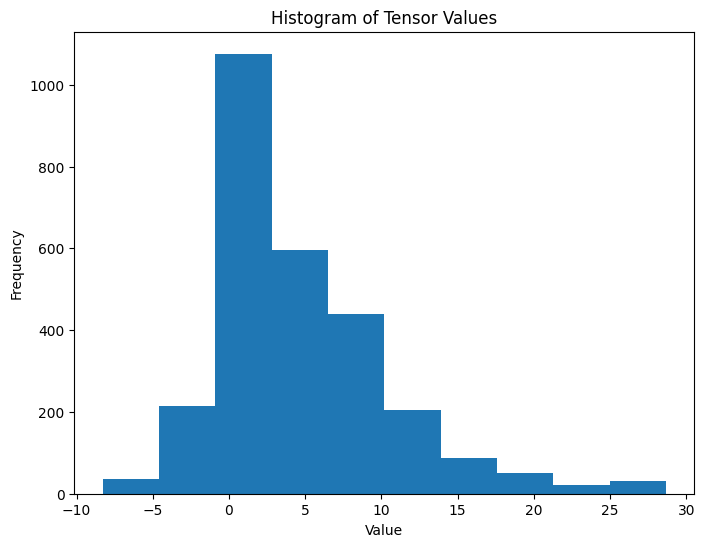

In [ ]:
draw_histogram(train_y)

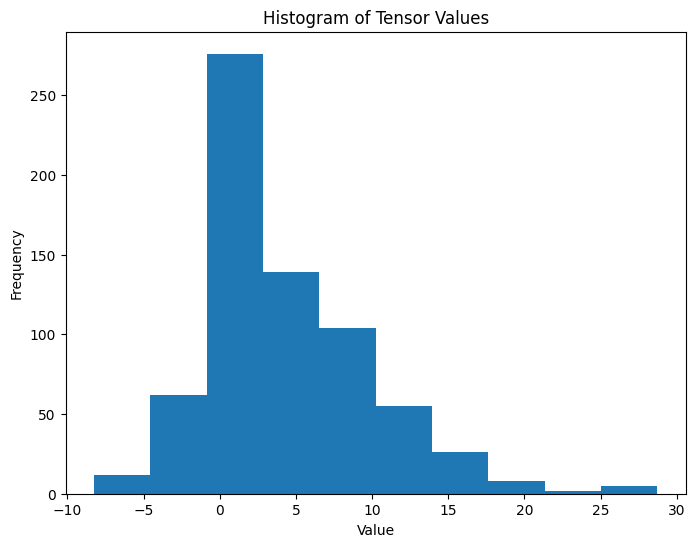

In [ ]:
draw_histogram(val_y)

# Model Definitions

### Broken CNN

In [ ]:
# Define the PyTorch model
class BrokenCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(in_channels=8, out_channels=128, kernel_size=(1, 1))
        self.conv2d_2 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=(1, 1))
        self.conv2d_3 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=(1, 1))
        self.conv2d_4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(1, 1))

        self.conv1d_1 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        self.conv1d_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=96, kernel_size=1)

        self.dense_1 = nn.Linear(96, 96)
        self.dense_2 = nn.Linear(96, 256)
        self.dense_3 = nn.Linear(256, 1)

        self.batchnorm_conv2d = nn.BatchNorm2d(128)
        self.batchnorm_conv1d = nn.BatchNorm1d(128)
        self.batchnorm_dense = nn.BatchNorm1d(96)
        self.batchnorm_flat = nn.BatchNorm1d(256)

    def forward(self, x):
        # Conv2D and Activation layers
        x = F.relu(self.conv2d_1(x))
        x = F.relu(self.conv2d_2(x))
        x = F.relu(self.conv2d_3(x))

        # MaxPooling2D and AvgPool2D layers
        xmax = F.max_pool2d(x, (1, 10)) * 0.3
        xavg = F.avg_pool2d(x, (1, 10)) * 0.7
        x = xmax + xavg
        x = torch.squeeze(x, 2)
        #x = self.batchnorm_conv2d(x)

        # Reshape for Conv1D
        x = x.permute(0, 3, 1, 2).squeeze(1)

        # Conv1D and Activation layers

        x = F.relu(self.conv1d_1(x))
        #x = self.batchnorm_conv1d(x)
        x = F.relu(self.conv1d_2(x))
        #x = self.batchnorm_conv1d(x)
        x = F.relu(self.conv1d_3(x))
        #x = self.batchnorm_dense(x)

        # MaxPooling1D and AvgPool1D layers
        xmax = F.max_pool1d(x, 11) * 0.3
        xavg = F.avg_pool1d(x, 11) * 0.7
        x = xmax + xavg
        x = torch.squeeze(x, 2)

        # Dense and Activation layers
        x = F.relu(self.dense_1(x))
        #x = self.batchnorm_dense(x)
        x = F.relu(self.dense_2(x))
        #x = self.batchnorm_flat(x)
        x = self.dense_3(x)


        return x

### New CNN

In [ ]:
# Define the PyTorch model
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv2d_1 = nn.Conv2d(in_channels=8, out_channels=128, kernel_size=(1, 1))
        self.conv2d_2 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=(1, 1))
        self.conv2d_3 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=(1, 1))
        self.conv2d_4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(1, 1))

        self.conv1d_1 = nn.Conv1d(in_channels=10, out_channels=96, kernel_size=11, stride=1, padding=5)
        self.conv1d_2 = nn.Conv1d(in_channels=96, out_channels=128, kernel_size=11, stride=1, padding=5)
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=98, kernel_size=11, stride=1, padding=5)
        self.conv1d_4 = nn.Conv1d(in_channels=98, out_channels=10, kernel_size=11, stride=1)
        self.dense_1 = nn.Linear(110, 1000)
        self.dense_2 = nn.Linear(1000, 256)
        self.dense_3 = nn.Linear(256, 1)

        # self.conv1d_1 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        # self.conv1d_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        # self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=96, kernel_size=1)

        # self.dense_1 = nn.Linear(96, 96)
        # self.dense_2 = nn.Linear(96, 256)
        # self.dense_3 = nn.Linear(256, 1)

        # self.batchnorm_conv2d = nn.BatchNorm2d(128)
        # self.batchnorm_conv1d = nn.BatchNorm1d(128)
        # self.batchnorm_dense = nn.BatchNorm1d(96)
        # self.batchnorm_flat = nn.BatchNorm1d(256)

    def forward(self, ipt):
        # Conv2D and Activation layers
        x = F.leaky_relu(self.conv2d_1(ipt))
        x = F.leaky_relu(self.conv2d_2(x))
        x = F.leaky_relu(self.conv2d_3(x))
        x = F.leaky_relu(self.conv2d_4(x))
        x = torch.flatten(x, start_dim=1)
        # x = x.squeeze(1)
        # x = x.permute(0, 2, 1).squeeze(1)
        # x = F.leaky_relu(self.conv1d_1(x))
        # x = F.leaky_relu(self.conv1d_2(x))
        # x = F.leaky_relu(self.conv1d_3(x))
        # x = F.leaky_relu(self.conv1d_4(x))
        # x = x.squeeze(2)
        x = F.leaky_relu(self.dense_1(x))
        x = F.leaky_relu(self.dense_2(x))
        x = self.dense_3(x)


        return x

In [ ]:
# Define the PyTorch model
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv2d_1 = nn.Conv2d(in_channels=10, out_channels=128, kernel_size=(1, 1))
        self.conv2d_2 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=(1, 1))
        self.conv2d_3 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=(1, 1))
        self.conv2d_4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(1, 1))

        self.conv1d_1 = nn.Conv1d(in_channels=10, out_channels=1, kernel_size=11, stride=1)
        self.dense_3 = nn.Linear(110, 1000)
        self.dense_4 = nn.Linear(1000, 1000)
        self.dense_5 = nn.Linear(1000, 1)
        self.relu = nn.SiLU()

    def forward(self, x):
        # Conv2D and Activation layers
        x = self.relu(self.conv2d_1(x))
        x = self.relu(self.conv2d_2(x))
        x = self.relu(self.conv2d_3(x))
        x = self.relu(self.conv2d_4(x))
        x = torch.flatten(x, 1)
        # print(x)
        # x = x.squeeze(1)
        # x = x.permute(0, 2, 1).squeeze(1)

        # x = F.leaky_relu(self.conv1d_1(x))

        # x= x.squeeze(1)
        x = self.relu(self.dense_3(x))
        x = self.relu(self.dense_4(x))
        x = self.dense_5(x)
        return x

In [ ]:
# Define the PyTorch model
class Basic(nn.Module):
    def __init__(self):
        super(Basic, self).__init__()
        self.dense_1 = nn.Linear(11, 100)
        self.dense_2 = nn.Linear(100, 200)
        self.dense_3 = nn.Linear(200, 1)
        self.relu = nn.SiLU()

    def forward(self, x):
        # Conv2D and Activation layers
        x = self.relu(self.dense_1(x))
        x = self.relu(self.dense_2(x))
        x = self.dense_3(x)
        x = torch.squeeze(x, 1)
        return x

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
        self.relu = nn.SiLU()
    def forward(self, l, g):
        #print(in_features_g)
        N, C, W, H = l.shape
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        #print(g_.shape)
        c = self.phi(self.relu(l_ + g_)) # batch_sizex1xWxH
        #print(c.shape)
        # compute attn map
        if self.normalize_attn:
            a = (c.view(N,1,-1)).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1) # weighted sum
        else:
            output = nn.AdaptiveAvgPool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

# Define the PyTorch model
class Skynet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv21 = nn.Conv2d(256,512,1,stride = 1)
        self.conv22 = nn.Conv2d(512, 256, 1,stride = 1)
        self.conv23 = nn.Conv2d(256,128, 1,stride = 1)
        self.conv24 = nn.Conv2d(8,128,1,stride = 1)
        self.conv25 = nn.Conv2d(128, 256, 1,stride = 1)
        self.conv26 = nn.Conv2d(256,128, 1,stride = 1)

        self.dconv21 = nn.Conv2d(10,128,1,stride = 1)
        self.dconv22 = nn.Conv2d(128, 160, 1,stride = 1)
        self.dconv23 = nn.Conv2d(160,128, 1,stride = 1)
        self.oconv21 = nn.Conv2d(10,128,1,stride = 1)
        self.oconv22 = nn.Conv2d(128, 160, 1,stride = 1)
        self.oconv23 = nn.Conv2d(160,128, 1,stride = 1)
        self.poolmax2 = nn.MaxPool2d(1,5)
        self.poolavg2 = nn.AvgPool2d(1,5)

        self.poolmax1 = nn.MaxPool1d(1,5)
        self.poolavg1 = nn.AvgPool1d(1,5)
        self.batch1 = nn.BatchNorm1d(2)

        self.conv11 = nn.Conv1d(2,128,1)
        self.batch2 = nn.BatchNorm1d(128)
        self.conv12 = nn.Conv1d(128,160,1)
        self.batch3 = nn.BatchNorm1d(160)
        self.conv13 = nn.Conv1d(160,96,1)
        self.batch4 = nn.BatchNorm1d(96)

        self.attentionmech = AttentionBlock(8, 128, 256, 4, normalize_attn=True)
        self.fc1 = nn.Linear(2112,512)
        self.fc2 = nn.Linear(512,256)
        self.batch6 = nn.BatchNorm1d(512)
        self.batch5 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,1)
        #self.squeeze = torch.squeeze(1)
        self.relu = nn.SiLU()

    def forward(self,x):
        temp = x
        dfence = x[:,:,:,:11]
        ofence = x[:,:,:,11:]

        dfence = self.relu(self.dconv21(dfence))
        dfence = self.relu(self.dconv22(dfence))
        dfence = self.relu(self.dconv23(dfence))

        ofence = self.relu(self.oconv21(ofence))
        ofence = self.relu(self.oconv22(ofence))
        ofence = self.relu(self.oconv23(ofence))

        x = self.relu(self.conv24(x))
        x = self.relu(self.conv25(x))
        x = self.relu(self.conv26(x))

        #print(ofence.shape,dfence.shape)
        x = torch.cat((torch.cat((dfence,ofence),dim = 3),x),dim = 1)
        #print(x.shape)
        #print(temp.shape)
        #x = torch.cat((dfence,ofence),dim = 3)

        x = self.relu(self.conv21(x))
        x = self.relu(self.conv22(x))
        x = self.relu(self.conv23(x))

        attention, x = self.attentionmech(temp,x)
        xmax = self.poolmax2(x)
        xavg = self.poolavg2(x)
        x = 0.3*xmax + 0.7*xavg
        #print(x.shape)

        #x = torch.flatten(x,start_dim=2,end_dim=3)
        x = self.batch1(x)
        x = self.relu(self.conv11(x))
        x = self.batch2(x)
        x = self.relu(self.conv12(x))
        x = self.batch3(x)
        x = self.relu(self.conv13(x))
        x = self.batch4(x)
        xmax = self.poolmax1(x)
        xavg = self.poolavg1(x)
        x = 0.3*xmax + 0.7*xavg
        x = torch.flatten(x,start_dim=1,end_dim=2)
        #print(x.shape)

        x = self.relu(self.fc1(x))
        #print(x.mT.shape)
        x = self.batch6(x)
        x = self.relu(self.fc2(x))
        #x = self.batch5(x.T)
        x = self.fc3(x)
        return x, attention

In [ ]:
# Define the PyTorch model
class Test(nn.Module):
    def __init__(self):
        super(Test, self).__init__()
        self.conv2d_1 = nn.Conv2d(in_channels=8, out_channels=128, kernel_size=(1, 1))
        self.conv2d_2 = nn.Conv2d(in_channels=128, out_channels=160, kernel_size=(1, 1))
        self.conv2d_3 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=(1, 1))
        self.conv2d_4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(1, 1))

        self.conv1d_1 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=11, stride=1)
        self.dense_1 = nn.Linear(10, 1000)
        self.dense_2 = nn.Linear(1000, 256)
        self.dense_3 = nn.Linear(880, 1)

        # self.conv1d_1 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        # self.conv1d_2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=1)
        # self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=96, kernel_size=1)

        # self.dense_1 = nn.Linear(96, 96)
        # self.dense_2 = nn.Linear(96, 256)
        # self.dense_3 = nn.Linear(256, 1)

        # self.batchnorm_conv2d = nn.BatchNorm2d(128)
        # self.batchnorm_conv1d = nn.BatchNorm1d(128)
        # self.batchnorm_dense = nn.BatchNorm1d(96)
        # self.batchnorm_flat = nn.BatchNorm1d(256)

    def forward(self, x):
        # # Conv2D and Activation layers
        # x = F.relu(self.conv2d_1(x))
        # x = F.relu(self.conv2d_2(x))
        # x = F.relu(self.conv2d_3(x))

        # # MaxPooling2D and AvgPool2D layers
        # xmax = F.max_pool2d(x, (1, 10)) * 0.3
        # xavg = F.avg_pool2d(x, (1, 10)) * 0.7
        # x = xmax + xavg
        # x = torch.squeeze(x, 2)
        # x = self.batchnorm_conv2d(x)

        # # Reshape for Conv1D
        # x = x.permute(0, 3, 1, 2).squeeze(1)

        # # Conv1D and Activation layers

        # x = F.relu(self.conv1d_1(x))
        # x = self.batchnorm_conv1d(x)
        # x = F.relu(self.conv1d_2(x))
        # x = self.batchnorm_conv1d(x)
        # x = F.relu(self.conv1d_3(x))
        # x = self.batchnorm_dense(x)

        # # MaxPooling1D and AvgPool1D layers
        # xmax = F.max_pool1d(x, 11) * 0.3
        # xavg = F.avg_pool1d(x, 11) * 0.7
        # x = xmax + xavg
        # x = torch.squeeze(x, 2)

        # # Dense and Activation layers
        # x = F.relu(self.dense_1(x))
        # x = self.batchnorm_dense(x)
        # x = F.relu(self.dense_2(x))
        # x = self.batchnorm_flat(x)
        # x = self.dense_3(x)
        x = x.reshape(x.shape[0], -1)
        print(x.shape)
        x = self.dense_3(x)


        return x

# Training Pipeline

### Create dataloaders to support batched training

In [ ]:
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
val_x

tensor([[-0.0850,  0.1891, -0.9918,  1.0288,  0.3158,  0.0687, -0.2947,  0.1789,
          0.0969, -1.2503, -0.1297]])

In [ ]:
def accuracy_within_one(y_pred, y_true):
    """
    Computes accuracy where a prediction is considered correct if it is within ±1 of the actual value.

    Parameters:
    y_pred (torch.Tensor): The predicted values.
    y_true (torch.Tensor): The actual values.

    Returns:
    float: The accuracy of the predictions within a range of ±1.
    """
    # Ensure that y_pred and y_true are both tensors
    if not isinstance(y_pred, torch.Tensor):
        y_pred = torch.tensor(y_pred)
    if not isinstance(y_true, torch.Tensor):
        y_true = torch.tensor(y_true)

    # Calculate the absolute difference
    diff = torch.abs(y_pred - y_true)

    # Count how many predictions are within ±1
    correct = torch.sum(diff <= 1.0)

    # Calculate the accuracy
    accuracy = correct.item() / len(y_pred)
    return accuracy

### Training loop

In [ ]:
model = CNN2()
print(model)

NameError: ignored

In [ ]:
for x, y in val_loader:
    print(y[0])
    print(y[0])
    print(x[0])
    print(x[0])
    break

tensor(1.2600)
tensor(1.2600)
tensor([-0.0850,  0.1891, -0.9918,  1.0288,  0.3158,  0.0687, -0.2947,  0.1789,
         0.0969, -1.2503, -0.1297])
tensor([-0.0850,  0.1891, -0.9918,  1.0288,  0.3158,  0.0687, -0.2947,  0.1789,
         0.0969, -1.2503, -0.1297])


In [ ]:
for x, y in train_loader:
    print(y[0])
    print(x[0])
    break

tensor(-0.1831)
tensor([[[ -6.4500,  12.4100,  -2.8300,  ...,  -0.4000,  10.6800,  22.6600],
         [-14.1400,   4.7200, -10.5200,  ...,  -8.0900,   2.9900,  14.9700],
         [-34.7400, -15.8800, -31.1200,  ..., -28.6900, -17.6100,  -5.6300],
         ...,
         [-26.3800,  -7.5200, -22.7600,  ..., -20.3300,  -9.2500,   2.7300],
         [ -4.6800,  14.1800,  -1.0600,  ...,   1.3700,  12.4500,  24.4300],
         [-16.8900,   1.9700, -13.2700,  ..., -10.8400,   0.2400,  12.2200]],

        [[ -9.0100,  -9.6100, -10.0300,  ...,  -4.7300,  16.2400,  10.2000],
         [-25.0000, -25.6000, -26.0200,  ..., -20.7200,   0.2500,  -5.7900],
         [ -1.7200,  -2.3200,  -2.7400,  ...,   2.5600,  23.5300,  17.4900],
         ...,
         [  5.3500,   4.7500,   4.3300,  ...,   9.6300,  30.6000,  24.5600],
         [ -1.0800,  -1.6800,  -2.1000,  ...,   3.2000,  24.1700,  18.1300],
         [-17.1900, -17.7900, -18.2100,  ..., -12.9100,   8.0600,   2.0200]],

        [[  3.7434,   3.7434

In [ ]:
for name, parameter in model.named_parameters():
    parameter.requires_grad = True

<generator object Module.parameters at 0x7b5c795f0580>

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
epochs = 100
model = Basic()
# for name, parameter in model.named_parameters():
#     parameter.requires_grad = True

layer_gradients = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.MSELoss()
# Train the model for <epochs> epochs
layer_gradients = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        # print(batch_x[0])
        # x[1] = x[1] * 0
        # print(x)
        optimizer.zero_grad()
        outputs = model(batch_x)
        # print(outputs)
        # print(batch_y)
        loss = criterion(outputs, batch_y)
        loss.backward()

        cur_layer_gradients = []
        for name, parameter in model.named_parameters():
            if parameter.grad is not None:
                # Compute the average of the absolute gradients for this layer
                avg_grad = parameter.grad.abs().mean()
                layer_gradients.append((name, avg_grad))
        layer_gradients.append(cur_layer_gradients)
        optimizer.step()

        # print("outputs")
        # print(outputs)
        # print("targets")
        # print(batch_y)
        train_loss += loss.item()
    train_loss /= len(train_loader)
    #Valudation step
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for cur_val_x, cur_val_y in val_loader:
            val_outputs = model(cur_val_x)
            val_acc += accuracy_within_one(val_outputs, cur_val_y)
            val_loss += criterion(val_outputs, cur_val_y).item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

    print(f"Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

Epoch 0, Train Loss: 20.78667355669427, Validation Loss: 10.590577488345218, Validation Accuracy: 0.30346820809248554
Epoch 1, Train Loss: 10.329539630805373, Validation Loss: 6.637357917824232, Validation Accuracy: 0.4031791907514451
Epoch 2, Train Loss: 6.0886935222845295, Validation Loss: 4.728142179437035, Validation Accuracy: 0.47109826589595377
Epoch 3, Train Loss: 4.036822586354133, Validation Loss: 3.2562924240193616, Validation Accuracy: 0.5447976878612717
Epoch 4, Train Loss: 3.153486856674378, Validation Loss: 2.3159170346711413, Validation Accuracy: 0.5780346820809249
Epoch 5, Train Loss: 2.3509446981677944, Validation Loss: 1.5209233485312992, Validation Accuracy: 0.6835260115606936
Epoch 6, Train Loss: 2.0600143527376895, Validation Loss: 1.66946767788445, Validation Accuracy: 0.6734104046242775
Epoch 7, Train Loss: 1.6629004648022208, Validation Loss: 1.0617660749434477, Validation Accuracy: 0.7427745664739884
Epoch 8, Train Loss: 1.3607076370334374, Validation Loss: 0.9

In [ ]:
print(layer_gradients)

[('conv2d_1.weight', tensor(0.0023)), ('conv2d_1.bias', tensor(0.0007)), ('conv2d_2.weight', tensor(0.0019)), ('conv2d_2.bias', tensor(0.0018)), ('conv2d_3.weight', tensor(0.0023)), ('conv2d_3.bias', tensor(0.0074)), ('conv2d_4.weight', tensor(0.0369)), ('conv2d_4.bias', tensor(0.3394)), ('dense_3.weight', tensor(0.0023)), ('dense_3.bias', tensor(0.0382)), ('dense_4.weight', tensor(0.0042)), ('dense_4.bias', tensor(0.1442)), ('dense_5.weight', tensor(0.1995)), ('dense_5.bias', tensor(17.6799)), [], ('conv2d_1.weight', tensor(0.0036)), ('conv2d_1.bias', tensor(0.0015)), ('conv2d_2.weight', tensor(0.0039)), ('conv2d_2.bias', tensor(0.0047)), ('conv2d_3.weight', tensor(0.0055)), ('conv2d_3.bias', tensor(0.0195)), ('conv2d_4.weight', tensor(0.0916)), ('conv2d_4.bias', tensor(0.8956)), ('dense_3.weight', tensor(0.0025)), ('dense_3.bias', tensor(0.0380)), ('dense_4.weight', tensor(0.0042)), ('dense_4.bias', tensor(0.1431)), ('dense_5.weight', tensor(0.1994)), ('dense_5.bias', tensor(17.5306)

In [ ]:
# Preprocessing the data
layers = sorted({name.split('.')[0] for name, _ in layer_gradients})
layer_data = {layer: [] for layer in layers}

for name, value in layer_gradients:
    layer = name.split('.')[0]
    layer_data[layer].append(value)

# Plotting the data
plt.figure(figsize=(15, 8))
for layer, values in layer_data.items():
    plt.plot(values, label=layer)

plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('Layer Values Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

ValueError: ignored

In [ ]:
print(outputs, batch_y)

tensor([[0.0876],
        [0.0871]], grad_fn=<SiluBackward0>) tensor([ 2.6000, 15.0300])


In [ ]:
print()

In [ ]:
layer_gradients = []
for name, parameter in model.named_parameters():
    if parameter.grad is not None:
        # Compute the average of the absolute gradients for this layer
        avg_grad = parameter.grad.abs().mean()
        layer_gradients.append((name, avg_grad))

# Sorting the gradients for better visualization
layer_gradients.sort(key=lambda x: x[1], reverse=True)

# Separating names and values for plotting
names, grads = zip(*layer_gradients)

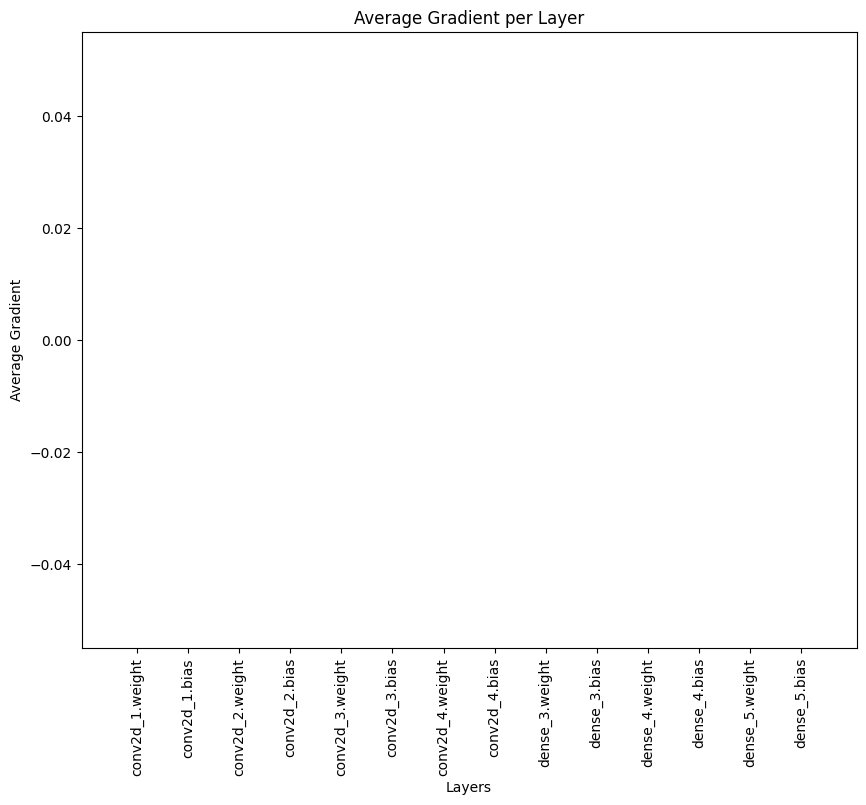

In [ ]:
plt.figure(figsize=(10, 8))
plt.bar(names, grads)
plt.xlabel('Layers')
plt.ylabel('Average Gradient')
plt.title('Average Gradient per Layer')
plt.xticks(rotation=90)  # Rotate names for better readability
plt.show()

In [ ]:
train_dataset[0][0].tolist()

[[[103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531,
   103.16999816894531],
  [109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938,
   109.16000366210938],
  [108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156,
   108.61000061035156],
  [103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625,
   103.69000244140625],
  [104.44999694824219,
   104.44999694824219,
   104.44999694824219,
   104.

In [ ]:
train_dataset[0][1]

tensor(101.1500, grad_fn=<SelectBackward0>)